In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

In [66]:
sird_df = pd.read_csv("sird_dataset.csv")

In [67]:
sird_df.head()

,Jour,Susceptibles,Infectés,Rétablis,Décès
0,0,0.998894,0.003197,-0.002455,-0.004622
1,1,0.991526,0.000409,0.010702,0.008857
2,2,0.982164,0.011018,0.004865,-0.001515
3,3,0.988132,0.008969,-0.006308,0.003571
4,4,0.971090,0.007307,0.005403,0.004894


Looking for empty rows

In [68]:
empty_rows = sird_df.isnull().all(axis=1).sum()
print (empty_rows)

0


Looking for negative values

In [69]:
negative_rows = (sird_df < 0).any(axis=1).sum()
print(negative_rows)

14


Data types verification

In [70]:
print(sird_df.dtypes)

Jour              int64
Susceptibles    float64
Infectés        float64
Rétablis        float64
Décès           float64
dtype: object


In [71]:
sird_df.Jour.max()

89

Check if the 'Jour' column is ordered

In [72]:
if sird_df['Jour'].is_monotonic_increasing:
    print("Les jours sont bien ordonnés.")
else:
    print("Les jours ne sont pas ordonnés.")

Les jours sont bien ordonnés.


SIRD proportions over time visualization

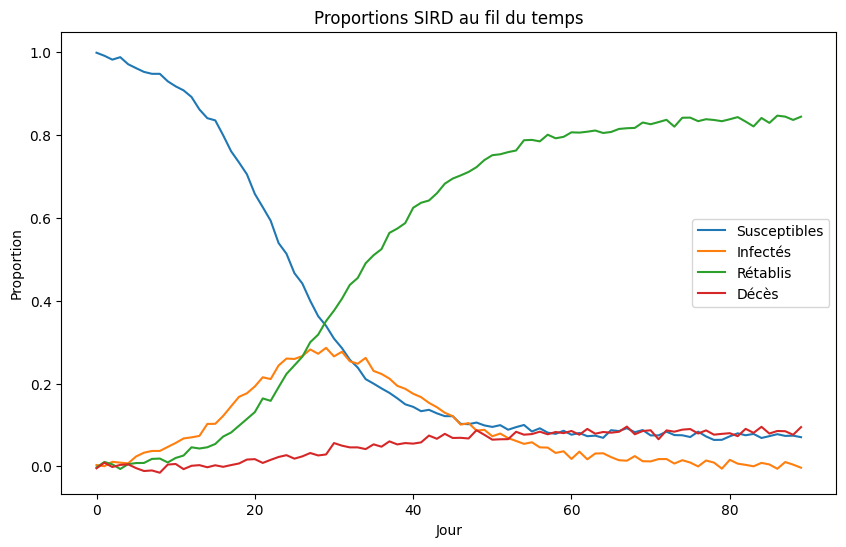

In [73]:
sird_df[['Susceptibles', 'Infectés', 'Rétablis', 'Décès']].plot(figsize=(10, 6))
plt.title("Proportions SIRD au fil du temps")
plt.xlabel("Jour")
plt.ylabel("Proportion")
plt.legend()
plt.show()

In [74]:
jours = sird_df.Jour.max()
step = 0.01
number_of_iterations = int(jours/step)

In [75]:
beta = 0.5
gamma = 0.15
mu = 0.015

S0 = 0.99
I0 = 0.01
R0 = 0
D0 = 0

def sird (beta, gamma, mu, S0, I0, R0, D0, number_of_iterations, step):
        S = [S0]
        I = [I0]
        R = [R0]
        D = [D0]

        for i in range(number_of_iterations):
            dS = -beta * S[i] * I[i] * step
            dI = (beta * S[i] * I[i] - (gamma + mu) * I[i]) * step
            dR = gamma * I[i] * step
            dD = mu * I[i] * step

            S.append(S[i] + dS)
            I.append(I[i] + dI)
            R.append(R[i] + dR)
            D.append(D[i] + dD)
           
        return S[::100], I[::100], R[::100], D[::100]     

In [76]:
S, I, R, D = sird(beta, gamma, mu, S0, I0, R0, D0, number_of_iterations, step)

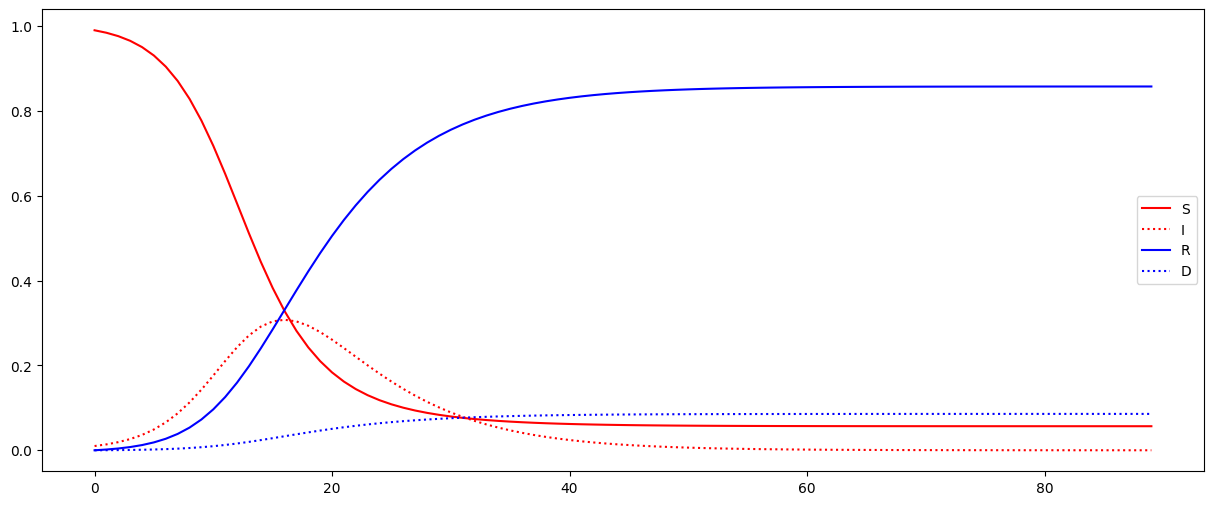

In [77]:
plt.figure(figsize=(15,6))
plt.plot(S, "r-")
plt.plot(I, "r:")
plt.plot(R, "b-")
plt.plot(D, "b:")
plt.legend(["S", "I", "R", "D"])
plt.show()

In [78]:
sird_df.head()

,Jour,Susceptibles,Infectés,Rétablis,Décès
0,0,0.998894,0.003197,-0.002455,-0.004622
1,1,0.991526,0.000409,0.010702,0.008857
2,2,0.982164,0.011018,0.004865,-0.001515
3,3,0.988132,0.008969,-0.006308,0.003571
4,4,0.971090,0.007307,0.005403,0.004894


In [79]:
def calculate_mse(actual_values, predicted_values):
    actual_values = np.array(actual_values)
    predicted_values = np.array(predicted_values)
    return np.mean((actual_values - predicted_values) ** 2)

In [80]:
def grid_search_sird(data, beta_range, gamma_range, mu_range, S0, I0, R0, D0, days, step_size):

    best_mse = float('inf')
    best_params = None
    steps = int(days / step_size)

    for beta in beta_range:
        for gamma in gamma_range:
            for mu in mu_range:
                S, I, R, D = sird(beta, gamma, mu, S0, I0, R0, D0, steps, step_size)
                # Échantillonnage des résultats du modèle pour correspondre aux points de données
                indices = np.linspace(0, len(S)-1, len(data), dtype=int)

                mse = (
                    calculate_mse(data['Susceptibles'], np.array(S)[indices]) +
                    calculate_mse(data['Infectés'], np.array(I)[indices]) +
                    calculate_mse(data['Rétablis'], np.array(R)[indices]) +
                    calculate_mse(data['Décès'], np.array(D)[indices])
                )
                if mse < best_mse:
                    best_mse = mse
                    best_params = (beta, gamma, mu)

    return best_params, best_mse

In [81]:
beta_values = np.linspace(0.25, 0.5, num=10)
gamma_values = np.linspace(0.08, 0.15, num=10)
mu_values = np.linspace(0.005, 0.015, num=10)

In [82]:
best_params, best_mse = grid_search_sird(sird_df, beta_values, gamma_values, mu_values, S0, I0, R0, D0, jours, step)


In [83]:
print(f"Paramètres optimaux : β={best_params[0]}, γ={best_params[1]}, μ={best_params[2]}")
print(f"mse : {best_mse}")

Paramètres optimaux : β=0.2777777777777778, γ=0.08777777777777777, μ=0.008333333333333333
mse : 0.0008016219798302741


In [84]:
beta = best_params[0]
gamma = best_params[1]
mu = best_params[2]

In [85]:
S, I, R, D = sird(beta, gamma, mu, S0, I0, R0, D0, number_of_iterations, step)

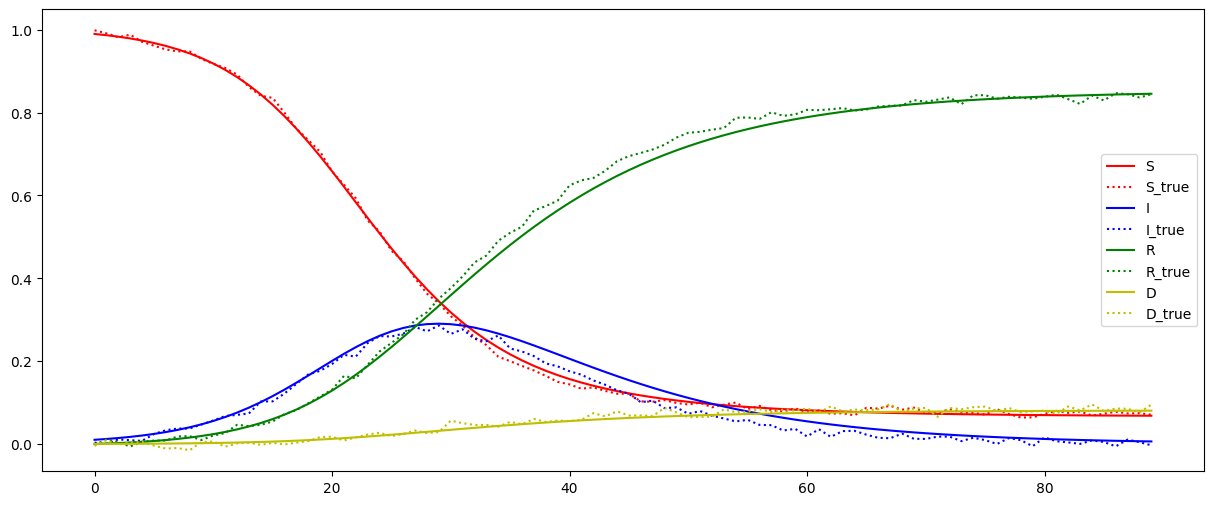

In [86]:
#4
import matplotlib.pyplot as plt

plt.figure(figsize=(15,6))
plt.plot(S, "r-")
plt.plot(sird_df["Susceptibles"], "r:")

plt.plot(I, "b-")
plt.plot(sird_df["Infectés"], "b:")

plt.plot(R, "g-")
plt.plot(sird_df["Rétablis"], "g:")

plt.plot(D, "y-")
plt.plot(sird_df["Décès"], "y:")

plt.legend(["S", "S_true", "I", "I_true","R","R_true","D","D_true"])

plt.show()

In [87]:
R0 = beta / (mu+gamma)
print(R0)

2.8901734104046244


R0 est le nombre moyen de personnes qu'un individu infecté peut contaminer dans une population entièrement susceptible.

Si 
R0 > 1 : L'épidémie se propage, car chaque personne infectée en contamine plus d'une.


Si 
R0 < 1 : L'épidémie s'éteint progressivement, car chaque personne infectée contamine en moyenne moins d'une personne.

In [88]:
import numpy as np
import matplotlib.pyplot as plt

def sird_with_intervention(beta, gamma, mu, S0, I0, R0, D0, number_of_iterations, step, intervention_day=None, beta_new=None):

    S = [S0]
    I = [I0]
    R = [R0]
    D = [D0]

    for i in range(number_of_iterations):
        # Applique l'intervention si on atteint le jour de l'intervention
        if intervention_day and i >= intervention_day:
            beta = beta_new

        dS = -beta * S[i] * I[i] * step
        dI = (beta * S[i] * I[i] - (gamma + mu) * I[i]) * step
        dR = gamma * I[i] * step
        dD = mu * I[i] * step

        S.append(S[i] + dS)
        I.append(I[i] + dI)
        R.append(R[i] + dR)
        D.append(D[i] + dD)

    return S[::100], I[::100], R[::100], D[::100]  # Échantillonnage pour la visualisation



In [89]:
# Paramètres
S0 = 0.99
I0 = 0.01
R0 = 0
D0 = 0
beta = 0.5
gamma = 0.15
mu = 0.015
intervention_day = 20  # Jour où l'intervention commence
beta_new = 0.3  # Nouvelle valeur de beta après l'intervention
jours = 100  # Nombre total de jours
step = 0.01 
number_of_iterations = int(jours / step)

In [90]:
#avec intervention
S_with_intervention, I_with_intervention, R_with_intervention, D_with_intervention = sird_with_intervention(beta, gamma, mu, S0, I0, R0, D0, number_of_iterations, step, intervention_day, beta_new)

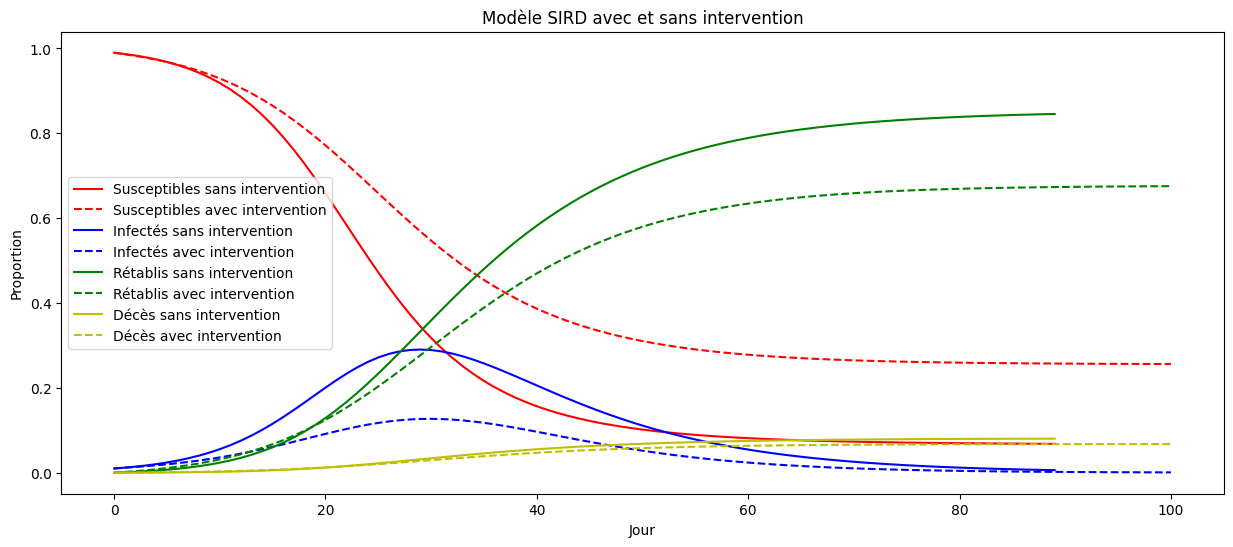

In [91]:
plt.figure(figsize=(15, 6))

# Proportion de S
plt.plot(S, 'r-', label="Susceptibles sans intervention")
plt.plot(S_with_intervention, 'r--', label="Susceptibles avec intervention")

# Proportion de I
plt.plot(I, 'b-', label="Infectés sans intervention")
plt.plot(I_with_intervention, 'b--', label="Infectés avec intervention")

# Proportion de R
plt.plot(R, 'g-', label="Rétablis sans intervention")
plt.plot(R_with_intervention, 'g--', label="Rétablis avec intervention")

# Proportion de D
plt.plot(D, 'y-', label="Décès sans intervention")
plt.plot(D_with_intervention, 'y--', label="Décès avec intervention")

# Titres et légendes
plt.title("Modèle SIRD avec et sans intervention")
plt.xlabel("Jour")
plt.ylabel("Proportion")
plt.legend()
plt.show()